In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras import backend as K 
from keras import Input

## 2012 Data

### LSTM Network Model

In [7]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [49]:
# load a list of files into an array of [samples, timesteps, features, xyz]
def load_group(filenames, prefix=''):
    loaded = list()
    for measure in filenames:
        measurements=list()
        for name in measure:
            data = load_file(prefix + name)
            measurements.append(data)
        loaded.append(measurements) 
    loaded=np.array(loaded)
    loaded=np.transpose(loaded, [2,3,0,1])
    return loaded

In [45]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames.append(['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt'])
    # body acceleration
    filenames.append(['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt'])
    # body gyroscope
    filenames.append(['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'])
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [16]:
def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    # one hot encode y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return X_train, y_train, X_test, y_test

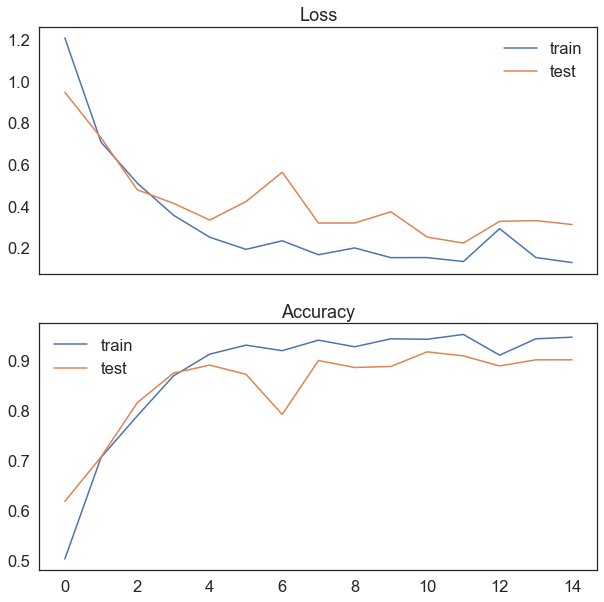

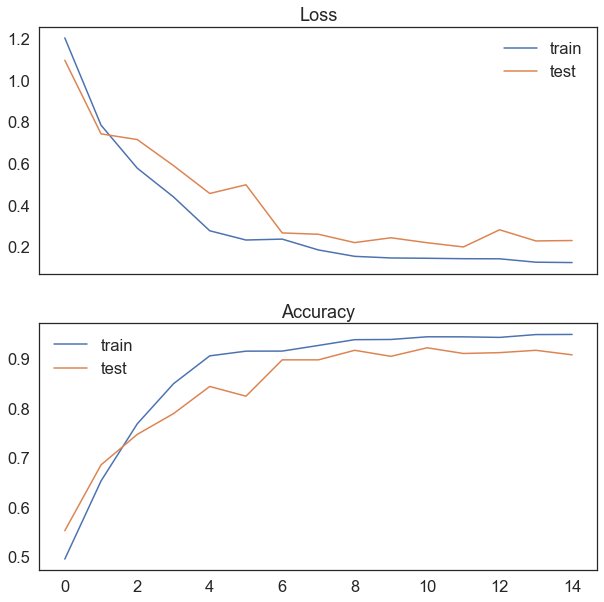

In [56]:
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)
for i in range(len(results)):
    fig, axes = plt.subplots(2,1, figsize=(10,10), sharex=True)
    axes[0].set_title('Loss')
    axes[0].plot(results[i]['loss'], label='train', )
    axes[0].plot(results[i]['val_loss'], label='test')
    axes[0].legend()
    #plot accuracy during training
    axes[1].set_title('Accuracy')
    axes[1].plot(results[i]['accuracy'], label='train')
    axes[1].plot(results[i]['val_accuracy'], label='test')
    axes[1].legend()
    plt.show()

### Base Model

In [50]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/2012/")
verbose, epochs, batch_size = 1, 25, 64

In [62]:
inp = Input(shape=(128, 3, 3))
x = TimeDistributed(LSTM(100, return_sequences=True))(inp)
model=Sequential()
model = model(inp, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

AttributeError: 'Tensor' object has no attribute 'compile'

In [64]:
?model

In [52]:
K.clear_session()
model = Sequential()
model.add(LSTM(100, input_shape=(128,3, 3)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
# evaluate model
accuracy = model.evaluate( X_test, y_test, batch_size=batch_size, verbose=verbose)

ValueError: Input 0 of layer lstm is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 128, 3, 3]

### CNN-LSTM Network Model

In [65]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/2012/")
verbose, epochs, batch_size = 1, 25, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

ValueError: cannot reshape array of size 8469504 into shape (7352,4,32,3)

In [ ]:
# define model
K.clear_session()
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Dropout(0.8)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)